<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Splitting-and-Preprocessing" data-toc-modified-id="Splitting-and-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Splitting and Preprocessing</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Re-estimating-model-with-funded-amount-dropped" data-toc-modified-id="Re-estimating-model-with-funded-amount-dropped-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Re-estimating model with funded amount dropped</a></span></li></ul></li><li><span><a href="#Forests-of-Randomized-Trees" data-toc-modified-id="Forests-of-Randomized-Trees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Forests of Randomized Trees</a></span><ul class="toc-item"><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Extremely-Randomized-Trees" data-toc-modified-id="Extremely-Randomized-Trees-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Extremely Randomized Trees</a></span></li></ul></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tests</a></span><ul class="toc-item"><li><span><a href="#SVM-RBF-Grid-Search" data-toc-modified-id="SVM-RBF-Grid-Search-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>SVM RBF Grid Search</a></span></li></ul></li><li><span><a href="#Save/Load" data-toc-modified-id="Save/Load-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save/Load</a></span></li></ul></div>

In [5]:
# Importing libraries
import pdb 
import glob
import copy
import math
import pickle
import csv

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    StratifiedShuffleSplit, cross_val_score, StratifiedKFold, \
    GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, \
    ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer, \
    precision_score, recall_score, \
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature

import missingno  # for visualizing missing data
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, pyll
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

# Load line profiler
%load_ext line_profiler

# Adjust number of CPU cores to use
# n_jobs=2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Splitting and Preprocessing

Let's start by loading the data we cleaned in the previous notebook. Next, we will drop categorical variables that have more than 50 categories, because these would cause a proliferation of columns when performing one-hot encoding below. A better strategy would be to seek to create dummy variables for only the most relevant or most common categories, or to extract a common meaning from different categories (e.g., use natural language processing for text fields), but we will leave this for future iterations of this project.

In [ ]:
# Load original data
with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file)  
    
# Find categorical variables with more than 50 unique values
unique_values_cat = all_data.select_dtypes(include='object') \
                        .nunique() \
                        .sort_values(ascending=False) 
# Drop categorical variables with more than 50 categories
all_data = all_data.drop(unique_values_cat[unique_values_cat > 50].index,
                 axis='columns')


We will now split the data into training, validation, and test set, containing 80%, 5%, and 15% of the data respectively. The validation set will be used not for hyperparameters tuning, for which we will use cross-validation, but to implement early stopping for XGBoost. (While we could combine validation and test set for the other models, I decided not to do so in order to compare performance on the same test set.) As discussed above, we will perform these splits randomly.  
In order to decide how to split the data into training, test, and validation set, we need to think about whether our observations are dependent or independent. 

###### Addressing dependency in the data
In our case, we are dealing with pooled cross-sectional data (observations on multiple different individuals, collected at different points in time). These data are almost certain to be dependent, because the default probability of loans issued at a similar date are likely to be more similar than for loans issued further apart. Put more precisely, the correlations of the *error terms* will be higher the closer the issue dates are to each other. Thus, it would be ideal to estimate models that take this time-series component into account.

However, I choose to leave modeling this dependency for further iterations of this project and treat the data as if they were an independent cross-section (and thus do *not* use any date variables as predictors).  The main reason is that taking the time-series factor into account would considerably increase complexity, which should only be added after more simple models have been successfully developed.  This increased complexity is not only due to the inherent nature of time-series models, but also to potentially insurmountable problems in splitting the data into *representative* training, test, validation sets that take this time-series nature into account, as explained below.

Ignoring the time-component should not impact performance too much because we are not dealing with proper time-series (observations on the *same* individual at different points in time), and as a result the correlation of the terms is likely not as strong as to overwhelm the influence of the predictors (as may be the case for autoregressive processes). While the fact that we are not able to take into account the default rates of recent loans as additional predictors will lower predictive accuracy somewhat, our model will still give us a good prediction of default *averaged* over all future economic scenarios. Note that recent default rates may not be very predictive of the default rates of new loans anyway, because our loans are scheduled to be paid back over a timeframe of 3 or 6 years.
Moreover, we should be able to capture most of the signal that exists in current default rates by simply adding indicators of macroeconomic performance (e.g., unemployment, GDP growth) as predictors, which would considerably reduce correlation between adjacent error terms. I will leave the use of such external data for later iterations of the project, though.

###### Implications for how to split the data 
If data are independent, we can simply split them randomly. If they are dependent, there are 2 more options: Another option is to train the models on the earliest portion of the data, and then split the later portion randomly into training and validation set. Finally, we could split the data into random chunks (each containing, say, 6 months of data), and to randomly assign some of these chunks to the training set, and then randomly split the other chunks into test and validation set. (The purpose of still creating test and validation set by random splits is to make sure that test and validation set have the same distribution, which makes model tuning easier.)

Since I do not model the time-component of the data – as explained above – I opt for splitting randomly (option 1). It may be tempting to instead train the model on the older data and measure predictive accuracy on the newer data (option 2) in order to get a better estimate of how our model will perform on future data.  The main argument for doing so is that the predictive accuracy computed this way would incorporate the additional uncertainty when making predictions on new loans due to factors such as changing macroeconomic conditions, as well as potential changes over time in the relationships between the predictors and the target. 

However, there are other countervailing factors that make splitting based on date potentially less generalizable.  The main problem is that since our whole data set only spans approximately one  business cycle, our validation and test sets would not contain observations drawn from across the manic cycle (they would come from a boom period). Since loan default rates are highly cyclical, the test accuracy computed this way might thus generalize *less* well to future data if predicting default rates during a boom period is systematically easier or harder.

Similarly, the relative performance of different learners, as well as the optimal hyperparameters, may vary across the business cycle.  This is another reason that we want to have our training, test, validation set drawn from across the business cycle in order to choose hyperparameters that train models which generalize best into the future.

If we later want to try to improve our predictions by modeling the time-series nature of the observations, we would not be able to conduct random splits.  In this case, we should choose option 3, randomly splitting the data set into chunks. The main challenge of this approach is to find an appropriate length for these chunks: On the one hand, since we only have 10 years overall, the intervals cannot be too long. If we don't want to be back at option 2, we have to split the data into at least 4 chunks, which gives us a length of 2.5 years each.  On the other hand, however, the intervals need to be long enough to capture the correlations between the error terms.  Furthermore, we need to remember that we cannot use the earliest portion of each chunk: If we want to model correlation of errors going back for one year, we have to throw away the first one year of data for each chunk away (because loan outcomes for the preceding year are part of a different chunk and can thus can not be used in order to avoid information leakage).  Thus, if we split our data into 4 chunks and model dependence going back one year, we lose 1/2.5 = 40% of our data.  Furthermore, this would reserve about half the data for the validation and test sets, which is not the most efficient use of our data. Furthermore,splitting the data into four chunks does not even guarantee that both training, test, validation set each contain samples from each part of the economic cycle, because the recession only lasted about 2 years (during which Lending Club did not issue as many loans yet, because it was early in its history), and we will use one year by splitting it across two chunks for the reasons explained above. 

As mentioned above, the fact that it is not even clear if a proper cross-validation could be conducted if we treat the data as dependent was one reason that I start by ignoring the time-dimension.

###### Other Preprocessing Steps 
To avoid information leakage into the training set, we need first split off the training set from the test and validation sets *before* we carry out the preprocessing steps. After imputing missing values, scaling, and performing one-hot encoding on the training set, we perform these operations on the test and validation sets using the parameters (each variable's median, mode, and standard deviation) estimated from the training set. 
 
I impute missing values with the median for numeric data and with the mode for categorical data.  While a univariate strategy such as this is suboptimal, because it discards information from the covariance between the different predictors, I did not find any good libraries for multivariate Imputation that integrate well into the scikit-learn workflow. A multivariate imputation for sklearn is under development (specifically MICE, multivariate imputation by chained equations), but it is not ready yet. I thus explored the fancyimpute package instead, but was faced with a chicken-and-egg problem: fancyimpute required  one-hot-encoding, but scikit-learn's one-hot-encoder in turn requires that missing data are already imputed. Thus, I decided to stick with univariate imputation. 


In [ ]:
def split_preprocess(X=all_data.drop('default', axis='columns'),
                     y=all_data.default,
                     train_size=.8, test_size=.2):
    """
    Splits the data into training and test set of specified size, 
    then applies preprocessing.
    """
    
    # Train-test split 
    # ================
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y,
                         train_size=train_size, test_size=test_size,
                         random_state=1, shuffle=True, stratify=y) 

    # Preprocessing
    # =============
    # Imputation and standardization for numeric features
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    numeric_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())]) 

    # Imputation and one-hot encoding for categorical features
    categorical_features = X_train.select_dtypes(include=[object]).columns
    categorical_transformer = Pipeline(steps =[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combining preprocessing for both kinds of features
    # Features of other dtypes – in our case, boolean – will be
    # appended at the end without transformation.
    # (Use only 1 core to avoid joblib error)
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric_transformer', 
                 numeric_transformer, numeric_features),
            ('categorical_transformer', 
                 categorical_transformer, categorical_features)],
        remainder='passthrough', n_jobs=1) 
    
    # Print dtypes of untransformed data
    print('data types of columns that were not transformed:\n {}'
            .format(X_train.select_dtypes(exclude=[np.number, object]) \
                    .dtypes.unique()))

    # Apply preprocessing
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
   

    # Get feature names
    # =================
    # Names of categorical variables after one-hot encoding
    categorical_names = preprocessor \
        .named_transformers_['categorical_transformer'] \
        .named_steps['onehot'] \
        .get_feature_names()
    # Names of columns with other dtype (should only be Boolean)
    other_names = X_train \
        .select_dtypes(exclude=[np.number, object]) \
        .columns
    # Concatenate feature names (Note that list with names of 
    # numeric features was already created above)
    feature_names = list(numeric_features) + \
        list(categorical_names) + list(other_names) 

    
    # Return results
    # ==============
    return(X_train_p, X_test_p, y_train, y_test, feature_names)
  

# Carry out splitting and preprocessing
X_train, X_test_val, y_train, y_test_val, feature_names = \
    split_preprocess(train_size=.8, test_size=.2)

# Further splitting to create validation set for XGB's early stopping
X_val, X_test, y_val, y_test = \
    train_test_split(X_test_val, y_test_val,
                     train_size=0.25, test_size=0.75,
                     random_state=1, shuffle=True, stratify=y_test) 

Since the above steps were computationally expensive, let's save the results to disk.

In [79]:
# Save preprocessed training and test sets
filenames = ['X_train', 'X_val', 'X_test',
                   'y_train', 'y_val', 'y_test']
files = [X_train, X_val, X_test, y_train, y_val, y_test]

for file, filename in zip(files, filenames):
    joblib.dump(file,
                'data_processed/{}.joblib'.format(filename))
# Delete temporary list to conserve memory
del files

# Also save feature names
joblib.dump(feature_names, 'data_processed/feature_names.joblib')

['data_processed/feature_names.joblib']

Next time, we can then load the data from disk:

In [6]:
# Load preprocessed data, incl. feature names 
X_train = joblib.load('data_processed/X_train.joblib')
X_val = joblib.load('data_processed/X_val.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_val = joblib.load('data_processed/y_val.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
feature_names = joblib.load('data_processed/feature_names.joblib')

## Predictive models

We will store important results from each model – its average precision score, a classification report (both before and after adjusting the classification threshold), and the feature importance – in a dictionary.

In [25]:
# Initialize dictionaries to store results
average_precisions = {}
classification_reports = {}
classification_reports_default_thresholds = {}
feature_importances = {}

In [15]:
# If these objects already (partially) exist, load them
average_precisions = joblib.load(
    'saved_models/average_precisions.joblib')
feature_importances = joblib.load(
    'saved_models/feature_importances.joblib')

Now we're ready to define two crucial functions that we will reuse for the individual models. The first one implements **Bayesian hyperparameters optimization using hyperopt**. I initially started out using grid search and randomized search, but these brute-force approaches turned out to be too computationally expensive for the size of my data. 

Thus, I turned to Bayesian hyperparameters optimization, which performs an intelligent search: We start by specifying a prior distribution for the hyperparameters. This formalizes our beliefs about which hyperparameters make sense *before we have seen the data.* Like randomized search but unlike grid search, this gives us the chance to not only specify the minimum and maximum values between which to confine our search, but it also allows us to concentrate probability mass around the most likely values in the center (e.g., through a (log)normal distribution), so that more plausible values are tried more frequently than possible but unlikely values. 

By contrast to a randomized search, however, we learn from the results from previous iterations: We start with the prior distribution that we defined above, and update our confidence about where the optimal hyperparameters lie after each trial. The distribution after each update is called the posterior distribution (it is a conditional probability, given the prior as well as the evidence observed so far). If the last values we tried gave us a good result on the validation set, it is likely that we have been moving in the right direction (and vice versa), and we update the probability distribution accordingly. The rules about how to update our confidence about which hyperparameters are optimal are defined by Bayes's Rule. In the beginning, when we have gathered few actual data, our posterior distribution will mainly be determined by the prior distribution we started with. But as we gather more evidence by trying additional hyperparameter combinations, the prior distribution will be swamped by the evidence from these trials and will concentrate more and more probability mass around the values that worked well.

Thus, for the first few iterations, the results will be similar to randomized search that draws hyperparameters from the same distributions that we use for our prior distributions. However, as we try more and more hyperparameters combinations, Bayesian optimization will increasingly concentrate our efforts on the subset of the search space that worked best previously. This is particularly important for models where we have many hyperparameters to tune (e.g., XGBoost). While randomized search is preferable to grid search, it still runs into the curse of dimensionality, because it becomes increasingly unlikely that a good combination of hyperparameters is selected randomly as the number of hyperparameters increases. Overall, thus, Bayesian optimization allows us to get a better accuracy for a given computational cost, or it allows us to attain a given accuracy at a (often much) lower computational cost.

One problem I faced when implementing this search using hyperopt is that this package only offers a limited choice of prior distributions. In particular, while I wanted to use a lognormal distribution for many variables, I also wanted to set a strict upper and lower bounds.  For example, for SVMs I wanted to avoid excessively high values for C, because this can increase training time by an order of magnitude.  An even bigger problem was that there were no good options to sample parameters that need to be integers, and that functions that were supposed to sample integers rounded from a normal distribution failed  to perform this type conversion.  Thus, I added a custom function for each learner that adjusts (rounds or converts) the parameters sampled by hyperopt before they are passed to the model.

In [6]:
# Function to carry out hyperparameter optimization
def find_best_hp(CLF, space, model_name, 
                 X_train, y_train, 
                 adjust_params=None,n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given classifier and search space."""
    
    # Trials object to track progress (not currently used)
    trials = Trials()

    # CSV file to track progress
    progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, CLF=CLF, 
                  progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""
        
        # Adjust parameters, if specified
        if adjust_params is not None:
            params = adjust_params(params)
    
        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)
    # Adjust best parameters, if specified
    if adjust_params is not None:
        best_params = adjust_params(best_params)

    # Re-fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train, y_train)
    
    # Save model to disk
    joblib.dump(clf, 'saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)

The second function we want to define here takes a model and calculates its average precision score (for both training and test set). It also writes the score for the test set to disk, since we will need that later to compare the performance of different learners. As we had to compute the predicted probabilities in the process, we go ahead and save those as well (since we will also need it later). Finally, this function gives the option to plot how the average precision score changed over time during Bayesian hyperparameters optimization.

In [10]:
# Calculate average precision
def return_save_ap(clf, model_name, X_test, y_test, 
                  X_train, y_train, validation_plot=False):
    """
    Returns, saves, and prints average precision score on train and test set; 
    saves score, As well as predictions, from *test* set. Optionally plots how 
    average precision changed over iterations (designed for hyperopt).
    """

    # Predict class
    y = clf.predict(X_test)
    # Save class prediction
    joblib.dump(y, f'predictions_test/y_{model_name}.joblib')
    
    # Predict class probabilitiesxgbxgb
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test)[:,1]
        y_score_train = clf.predict_proba(X_train)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test)
        y_score_train = clf.decision_function(X_train)
       
    # Save predictions for test set
    joblib.dump(y_score, f'predictions_test/y_score_{model_name}.joblib')
    
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)
    ap_score_train = average_precision_score(y_train, y_score_train)
    
    # Print AP
    print('Best average precision score on *test* set: {:.4f}' \
              .format(ap_score))
    print('Best average precision score on *training* set: {:.4f}' \
              .format(ap_score_train))
    
    # Plot AP, if specified
    if validation_plot:
        # Load progress file with validation performance
        progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
        progress_file = pd.read_csv(progress_file_path)

        # Extract AP for each iteration
        ap = - progress_file.loss
        ap.plot()
        plt.title('Performance during Cross-Validation')
        plt.ylabel('Average Precision')
        plt.xlabel('Iteration');
        
    # Return average precision
    return ap_score

The following function plots a confusion matrix.

In [51]:
# Plot confusion matrix 
def plot_confusion_matrix(y_pred, y_test=y_test, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

The following two functions help us visualize the trade-off between precision and recall, and then to make class predictions based on the appropriate threshold we choose.

In [61]:
# Define function to make a prediction with custom threshold
def custom_prediction(proba_or_dist, threshold):
    """
    Makes predictions for binary classification from probabilities or distance
    to separating hyperplane, given a custom threshold.
    """

    return (proba_or_dist > threshold).astype(int)


# Define function to plot effect of threshold on precision and recall
def plot_threshold(proba_or_dist, y_true=y_test, thresholds=None):
    """
    Plot precision and recall as a function of decision threshold for an array of
    probabilities or distances to separating hyperplane.

    If no custom list of thresholds is supplied, it defaults to a grid of length 
    100, spanning between the minimum and maximum probability/distance. (In
    order to avoid thresholds that assign all observations to a single class, 
    the smallest and largest thresholds are offset by 0.01 from the minimum and 
    maximum probability/distance.)

    Parameters
    ----------
    proba_or_dist: array-like
        Probabilities or distance from separating hyperplane
    y_true: array-like
        True values of target variable.
    thresholds: list-like
        Custom thresholds. Optional.  
        
    Returns
    -------
        None
    """
    
    # Initialize dictionaries to store results
    classes = {}
    precisions = {}
    recalls = {}
            
    # If no custom thresholds were passed, make grid between minimum and maximum
    # values for probability or distance.
    if thresholds is None:
        thresholds = np.linspace(proba_or_dist.min() + 0.01,
                                 proba_or_dist.max() - 0.01, 100)

    # Iterate over thresholds
    for threshold in thresholds:
        # Classify as 1 if probability/distance is greater than threshold, else 0
        classes[threshold] = custom_prediction(proba_or_dist, threshold)

        # Compute precision and recall
        precisions[threshold] = precision_score(y_true, classes[threshold])
        recalls[threshold] = recall_score(y_true, classes[threshold])

    # Combine precision and recall into a data frame, indexed by threshold
    pr_rec = pd.DataFrame({'precision': precisions, 'recall': recalls})

    # Plot results
    pr_rec.plot()
    plt.title('Effect of threshold on Precision and Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision\nRecall')
    plt.show()

In [70]:
def plot_precision_recall(y_pred, y_test=y_test):
    """Plots precision-recall curve."""

    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # pdb.set_trace()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.figtext(0.2, 0.2, 'Average Precision={0:0.3f}' \
                                    .format(average_precision))
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show();

In [73]:
def plot_roc(y_pred, y_test=y_test, model_name=None):
    """Plots ROC curve."""

    false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = {0:.3f}'.format(roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='ROC Curve'
    # Add custom title, if specified
    if model_name is not None:
        title = ', '.join([title, model_name])
    plt.title(title)
    plt.show();

## Logistic regression
We are now ready to fit the first model. We will start with two simple linear models, logistic regression and linear SVM. Because of the size of our data (about 800,000 observations and 130 variables), batch gradient descent would be too slow, so I use stochastic gradient descent. Scikit-learn implements this as the SGDClassifier. To train a logistic regression, we simply use a log-loss.

As mentioned above, we are going to use Bayesian optimization, implemented inHyperopt  to tune the hyperparameters. The first step is to decide which hyperparameters we want to optimize. I chose the regularization parameter alpha as well as the L1 ratio to implement elastic net regularization. Next, we need to specify appropriate prior distributions for these parameters. 

Let us start with alpha, which determines the regularization strength. In addition, it is used to set the initial learning rate (because I set the learning rate to "optimal"). For its prior distribution, I use a lognormal distribution, which concentrates probability mass around the neighborhood most likely a priori (scikit-learn's default of 0.001).

To parameterize this distribution, we need to specify the mean and standard deviation of a normal distribution, and hyperopt then applies an exponential transformation.  One potential point of confusion is that hyperopt uses the *natural* exponential function, whereas np.logspace – which is commonly used for grid search – uses base 10. To center the distribution at 0.001, we thus pass a mean parameter of log(0.001) to the normal distribution.  
Setting the variance parameter is less intuitive, so I simply experiment with different values until most of the samples fall within the range suggested in the documentation, 1E-7 to 1E-1.

Descriptive statistics:
 count    1.000000e+03
mean     3.405910e-01
std      6.144989e+00
min      5.383675e-10
5%       1.481990e-07
50%      1.055895e-04
95%      6.433022e-02
max      1.353450e+02
dtype: float64


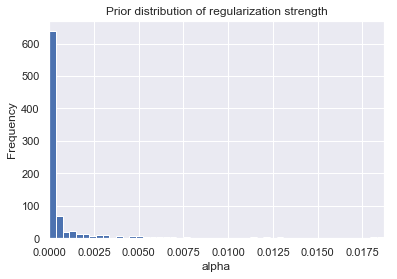

In [75]:
# Inspect prior distribution for alpha
alpha_distr = hp.lognormal('alpha', np.log(1E-4), 4)
samples = pd.Series(
    [pyll.stochastic.sample(alpha_distr) for i in range(1000)])

# Descriptive statistics
print('Descriptive statistics:\n', 
      samples.describe(percentiles =[0.05, 0.5, 0.95]))

# Plot (ignore outliers above 90th percentile)
samples_to_plot = samples[samples < samples.quantile(.9)]
samples_to_plot.plot(kind='hist', bins=50)
plt.xlabel('alpha')
plt.xlim([0, samples.quantile(0.9)])
plt.title('Prior distribution of regularization strength')
plt.show()

The other hyperparameters we want to tune is the L1 ratio, which determines the relative amount of the L1 and L2 penalty. Since this parameter is bounded between 0 and 1, we simply use a uniform distribution for its prior.

The other parameters should be self-explanatory.  Since our classes are imbalanced (only about one in five borrower defaults), we set the class weight to balanced, so that the rarer cases (default) are weighted more heavily. For the maximum number of iterations and the tolerance, we use the default parameters for the next version of scikit-learn (21.0).

We are now ready to train the model. Note that the metric that is optimized is average precision on the validation set. This measure is similar to the commonly used metric of the area under the ROC curve, but is better suited to unbalanced classification problems such as ours. The precise meaning of The average precision score is less straightforward, but it is roughly equal to the area under the precision-recall curve.

In [7]:
# Search space
space = {
    'loss': 'log',
    'penalty': 'elasticnet',
    'class_weight': 'balanced',
    'max_iter': 1000,
    'tol':1E-3,
    'random_state': 1,
    'alpha': hp.lognormal('alpha', np.log(1E-4), 4),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

# Find best hyperparameters (defined above)
find_best_hp(SGDClassifier, space, model_name='lr_hp',
              X_train=X_train, y_train=y_train,
              max_evals=40, n_jobs=3, n_folds=3)

{'alpha': 0.0005290883420165692, 'class_weight': 'balanced', 'l1_ratio': 0.5489442848597649, 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet', 'random_state': 1, 'tol': 0.001}


In [15]:
# Load saved model from disk, if necessary
lr_hp = joblib.load('saved_models/lr_hp.joblib')

Let's take a look at the average precision score of our model:

In [55]:
# Print and save average precision; save predictions
average_precisions['lr'] = return_save_ap(
    lr_hp, 'lr_hp', X_test, y_test,
    X_train=X_train, y_train=y_train)

Best average precision score on *test* set: 0.3922
Best average precision score on *training* set: 0.3908


Firstly, we see that we get similar accuracy on the training and test set. This is reassuring, because it means that we tuned our regularization parameters properly.

It is harder to interpret the absolute size. This statistic is bounded by zero and one, but what constitutes a good score depends on the difficulty of the classification problem. To get a better intuition what our score means, let's plot the precision-recall curve.

In [66]:
##  Load predictions from disk, if necessary
# Class prediction
y_lr = joblib.load('predictions_test/y_lr_hp.joblib')
# Predicted probability
y_proba_lr = joblib.load('predictions_test/y_score_lr_hp.joblib')

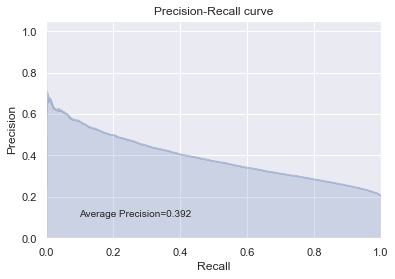

In [71]:
# Plot precision recall curve 
plot_precision_recall(y_proba_lr)

We see that, if we wanted to identify half the borrowers who end up defaulting (recall = 0.5), only about one in three borrowers predicted to default will actually do so (precision = 0.33). While this accuracy may seem disappointing, note that these calculations exclude applicants who were denied credit in the first place: Presumably, the applicant's most easily identifiable as not credited worth the were already screened out in this first stage, and the applicants who are harder to identify as having a high probability of default are left. 

For demonstration purposes, let's also plot the ROC curve.

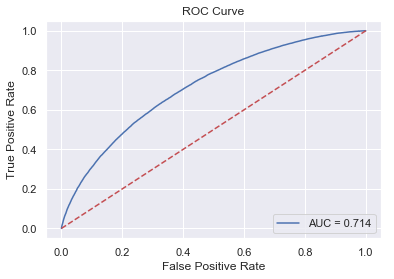

In [74]:
# Plot ROC curve 
plot_roc(y_proba_lr)

Note that these plots are based on our predicted probabilities rather than any hard (class) predictions. By default, scikit-learn will use a threshold of 0.5 to generate hard predictions.  In other words, If a borrower's default risk is greater than 50%, we'll predict that they will default.  However, it may make sense to deviate from this threshold if the cost of false positives and false negatives is asymmetrical. 

In our case, we probably want to err on the side of caution, because the cost of one default is much higher than the income lost from making one fewer loan. How to precisely weigh these two different costs is a much more complicated issue than we can solve here, in part because we do not of knowledge about all the costs associated with each.  This decision would also be easier if we were able to model the net present value of each loan rather than a simple binary prediction of default or no default, because the cost of default depends in large part on how much a borrower pays back before the default.  Unfortunately though, as explained in the first notebook, we did not have the necessary data to compute this more appropriate target variable. 

Let's take a look at this trade-off by plotting precision and recall as a function of the threshold:

In [67]:
# Plot confusion matrix
plot_confusion_matrix(y_lr)

Predicted   True  False
Actual                 
True       0.130  0.075
False      0.262  0.534


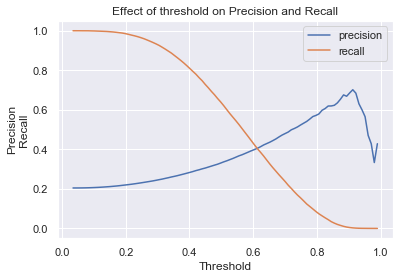

In [69]:
# Plot effect of decision threshold
plot_threshold(y_proba_lr)

As mentioned above, we care more about recall than precision (because the cost of default is higher than the cost of turning down a borrower), but we don't have the full information here to find the precise optimum for this trade-off. A reasonable goal seems to be to identify half the defaults (recall = 0.5), which gives us a precision of a little over 35%. In other words, we are willing to turn away (a little under) two applicants who would not default in order to successfully identify one applicant who will default.

This decision corresponds to picking a decision the threshold of 0.55, i.e. we turn down all applicants whose probability of default is greater than 55%.  Note that we get a similar result than if we had not adjusted the threshold at all, but as we will see below, this is not always the case.

The final step is to take a look which features were most predictive of default. For logistic regression, we simply need to take a look at the coefficient vector. Because of the large number of features, we will first sort these values. Next, we will take a look at the 20 features that increase the probability of default the most, and the 20 variables that decrease at the most:

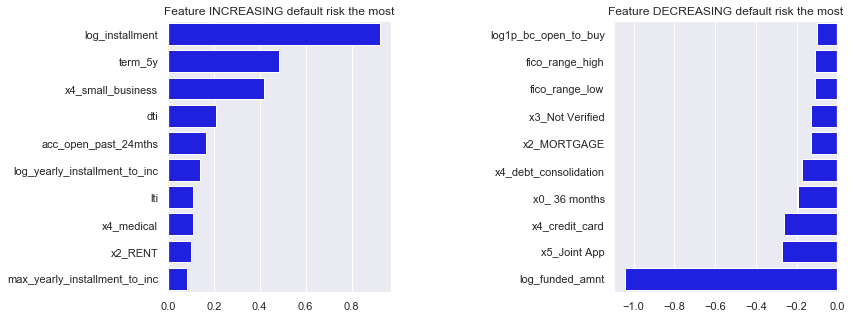

In [45]:
# Compute and save feature importance
feature_importances['lr'] = pd.Series(
    lr_hp.coef_[0], 
    index=feature_names) \
        .sort_values(ascending=False)

# Get top and bottom features
lr_top = feature_importances['lr'].head(10)
lr_bottom = feature_importances['lr'].tail(10)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
# Plot top features
sns.barplot(x=lr_top, y=lr_top.index, 
            color='blue', ax=ax[0])
ax[0].set_title('Feature INCREASING default risk the most');

# Plot bottom features
sns.barplot(x=lr_bottom, y=lr_bottom.index, 
            color='blue', ax=ax[1])
ax[1].set_title('Feature DECREASING default risk the most');

# Increase horizontal space between plots
fig.subplots_adjust(wspace=1)
plt.show();

Two variables standout is most important, the monthly installment as well as the funded amount. However, note that the direction of the latter is contrary to what we expect: The higher the amount funded, the *lower* the default risk.  Note that regression coefficients are interpreted as *partial* effects (i.e., holding the value of other variables constant), so this surprising result cannot simply be due to the fact that borrowers who received funding for a higher amount have other desirable characteristics that makes them less likely to default.  

Instead, the likely reason for this suspicious result is let these variables are likely highly correlated. In fact - as mentioned in the previous notebook when normalizing the monetary quantities by income - this actually introduced *multicollinearity*, i.e. near-linear dependence between some of these variables. As a result, learning algorithm has trouble adjudicating from which variable the effect stems. While it can still estimate the effect of a linear combination of these variables – and it does not constrain the weight of each individual variable between zero and one – the coefficients of each individual variable can be artificially large and absolute value. 

If we were primarily interested in which features are most important, we would thus have to eliminate some of these redundant variables. However, since our primary interest is in *prediction*, it was better not to discard any information by dropping variables. Note that it is crucial that we use regularization, because it makes the estimation of this equation  possible even though the feature matrix does not have full column rank.

To test this explanation, let's reestimate the model with the funded amount dropped.  We expect to see a slightly lower average precision score, but more sensible coefficients (in particular, that the effect of the most important variables are in the expected direction). 

### Re-estimating model with funded amount dropped

Let's now reestimate the model without log(funded amount), whose collinearity with other variables made the feature importances uninterpretable.

In [52]:
# Training set without log(funded amount)
X_train_2 = pd.DataFrame(X_train, columns=feature_names) \
    .drop('log_funded_amnt', axis=1) \
    .values

# Test set without log(funded amount)
X_test_2 = pd.DataFrame(X_test, columns=feature_names) \
    .drop('log_funded_amnt', axis=1) \
    .values

# Feature name without log(funded amount)
feature_names_2 = list(filter(lambda x: x != 'log_funded_amnt', feature_names))

In [ ]:
# Search space
space = {
    'loss': 'log',
    'penalty': 'elasticnet',
    'class_weight': 'balanced',
    'max_iter': 1000,
    'tol':1E-3,
    'random_state': 1,
    'alpha': hp.lognormal('alpha', np.log(1E-4), 4),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

# Find best hyperparameters
find_best_hp(SGDClassifier, space, model_name='lr_hp_2',
              X_train=X_train_2, y_train=y_train,
              max_evals=40, n_jobs=3, n_folds=3)

In [49]:
#  Load saved model from disk, if necessary
lr_hp_2 = joblib.load('saved_models/lr_hp_2.joblib')

In [92]:
# Print and save average precision
return_save_ap(
    lr_hp_2, 'lr_hp_2', X_test_2, y_test,
    X_train=X_train_2, y_train=y_train)

Best average precision score on *test* set: 0.3904
Best average precision score on *training* set: 0.3889


0.39044948850259353

This confirms our first suspicion: the accuracy is similar but slightly lower (0.3904 compared to 0.3922).  Let's now take a look at the most important features:

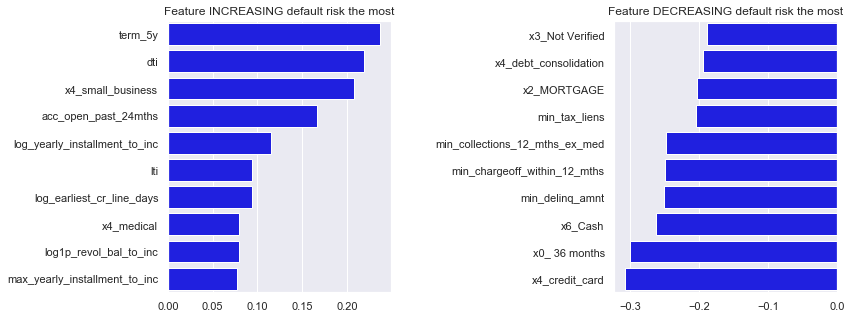

In [53]:
# Compute and save feature importance
feature_importances['lr_2'] = pd.Series(
    lr_hp_2.coef_[0], 
    index=feature_names_2) \
        .sort_values(ascending=False)

# Get top and bottom features
lr_2_top = feature_importances['lr_2'].head(10)
lr_2_bottom = feature_importances['lr_2'].tail(10)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
# Plot top features
sns.barplot(x=lr_2_top, y=lr_2_top.index, 
            color='blue', ax=ax[0])
ax[0].set_title('Feature INCREASING default risk the most');

# Plot bottom features
sns.barplot(x=lr_2_bottom, y=lr_2_bottom.index, 
            color='blue', ax=ax[1])
ax[1].set_title('Feature DECREASING default risk the most');

# Increase horizontal space between plots
fig.subplots_adjust(wspace=1)
plt.show();

Right away, we notice that the top coefficients got considerably much smaller in absolute value (by a factor of three). This is a good sign that we might have eliminated multicollinearity sufficiently.

The top 5 features *increasing* the default risk contain many of the expected factors, such as a longer term (5 years), a higher debt-to-income ratio ("dti"), and higher installment-to-income ratio.  It is also not surprising that using the loan for a small business increases the risk.  Regarding the factors *decreasing* the default risk the most, it makes sense to see a shorter loan duration(3 years) or the fact that the applicant has having zero ("min_") tax liens, collections, charge-offs, and delinquent  amount. It is more surprising to see using the loan to pay a credit card decreases default risk. The cash variable refers to the disbursement method, and we do not have any prior expectations what the effect of this would be (the other alternative is direct pay).

Overall, thus, the suspicion that the feature importance of the main model (with no columns dropped) is not interpretable seems to be correct.  However, since we primarily are interested in prediction, we will stick with this model.

## Forests of Randomized Trees
### Random Forests

In [20]:
# Compute sqrt of number of features for baseline max_features
sqrt_n_ft = np.sqrt(X_train.shape[1])
sqrt_n_ft

# Define search space for hyperparameters
space = {'criterion': hp.choice('criterion', ['gini', 'entropy']),
         'max_depth': hp.uniform('max_depth', 5, 100),
         'max_features': hp.normal('max_features',
                                    sqrt_n_ft, 0.25*sqrt_n_ft),
         'min_samples_leaf': hp.uniform('min n_samples_leaf', 1, 200),
         'class_weight': 'balanced',
         'n_estimators': 100, 
         'random_state': 1}

In [ ]:
# Function to convert sampled parameters to integer or make positive, etc., 
# where necessary
def adjust_params_rf(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Convert sampled parameters to integer, where  applicable
    params['max_depth'] = round(params['max_depth'])
    params['max_features'] = round(params['max_features'])
    params['min_samples_leaf'] = round(params['min_samples_leaf'])
    
    # Set upper or lower bunds for parameters, where applicable
    if params['max_features'] < 1:
        params['max_features'] = 1
        
    # Return modified parameters
    return params

In [ ]:
MAX_EVALS = 50
N_JOBS = 3

# Find best hyperparameters
find_best_hp(RandomForestClassifier, space, 
             model_name='rf_hp', 
             X_train=X_train, y_train=y_train, 
             adjust_params=adjust_params_rf, 
             max_evals=MAX_EVALS, n_jobs=N_JOBS, 
             n_folds=3)

In [43]:
# Load saved model from disk, if necessary
rf_hp = joblib.load('saved_models/rf_hp.joblib')

In [44]:
# Print and save average precision; save predictions
average_precisions['rf'] = return_save_ap(
    rf_hp, 'rf_hp', X_test, y_test,
    X_train=X_train, y_train=y_train)

Best average precision score on *test* set: 0.3940
Best average precision score on *training* set: 0.6122


In [134]:
# Compute and save feature importance
feature_importances['rf'] = pd.Series(
    rf_hp.feature_importances_, 
    index=feature_names) \
        .sort_values(ascending=False)
#Print
feature_importances['rf']

dti                                 4.936790e-02
log_yearly_installment_to_inc       4.897405e-02
fico_range_low                      4.301309e-02
x0_ 60 months                       4.097101e-02
term_5y                             4.021893e-02
fico_range_high                     3.857527e-02
lti                                 3.177360e-02
log1p_bc_open_to_buy                2.595297e-02
log1p_tot_hi_cred_lim               2.510332e-02
log1p_avg_cur_bal                   2.490045e-02
acc_open_past_24mths                2.357594e-02
x0_ 36 months                       2.295674e-02
log_installment                     2.274231e-02
log1p_total_bc_limit                2.242405e-02
log1p_revol_bal_to_inc              2.168882e-02
log1p_annual_inc                    2.063381e-02
revol_util                          2.038378e-02
log_earliest_cr_line_days           2.031587e-02
log_mo_sin_old_rev_tl_op            2.006425e-02
log1p_revol_bal                     1.952347e-02
log1p_total_rev_hi_l

### Extremely Randomized Trees

In [21]:
# Define search space for hyperparameters
space = {'criterion': hp.choice('criterion', ['gini', 'entropy']),
         'max_depth': hp.uniform('max_depth', 5, 100),
         'max_features': hp.normal('max_features',
                                    sqrt_n_ft, 0.25*sqrt_n_ft),
         'min_samples_leaf': hp.uniform('min n_samples_leaf', 1, 200),
         'class_weight': 'balanced',
         'n_estimators': 1000,  # Only difference to random forests
         'random_state': 1}

In [ ]:
MAX_EVALS = 30
N_JOBS = 1

# Find best hyperparameters 
find_best_hp(ExtraTreesClassifier, space, model_name='et_hp',
              X_train=X_train, y_train=y_train,
              adjust_params=adjust_params_rf,  # Reuse from RF
              max_evals=MAX_EVALS, n_jobs=N_JOBS, n_folds=1) # No CV

In [ ]:
return_save_ap(rf, 'rf', X_test, y_test)

In [ ]:
average_precision

##  XGBoost

Since we have a lot of parameters to tune, we need a smart way of searching over the different parameters that avoids the combinatorial explosion that would result from a simultaneous grid search over all parameters.  

In the following, I will follow the suggestions from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for plausible ranges for the hyperparameters.  However, since I will use Bayesian optimization rather than brute force, I am able to avoid having to repeatedly optimize a small number of parameters at a time. Instead, I will optimize all tree-specific parameters at once, using a relatively higher learning rate to speed up training. Subsequently, I will reestimate the model on the training set with the parameters identified in the previous step, but use a smaller learning rate for increased accuracy. 

During both of the steps, I will use early stopping to determine the optimal number of trees.  To that end, I split off a quarter of the original training set to use as the validation set for early stopping. Since the original training set has about 200,000 observations, we will still have around 150,000 observations left as the new test set for the final XGBoost classifier. This is more than enough to measure performance with very high accuracy.

I will be using XGBoost's native API rather than the Scikit-learn API. This has several benefits, such as being able to use XGBoost's native data format, which increases performance.  Thus, let's start by converting the data.

In [102]:
# Remove "<" from feature names, since this causes problems for xgboost
feature_names_xgb = [x.replace('<', '_less_than_') for x in feature_names]

# Convert data to DMatrix 
data_xgb_train = xgb.DMatrix(data=X_train, label=y_train,
                             feature_names=feature_names_xgb, nthread=-1)
data_xgb_test = xgb.DMatrix(data=X_test, label=y_test,
                            feature_names=feature_names_xgb)
data_xgb_val = xgb.DMatrix(data=X_val, label=y_val,
                            feature_names=feature_names_xgb)

Since we are not using the sklearn API, we won't be able to reuse the function defined above for Bayesian hyperparameters optimization. Instead, let's adapt the code for XGBoost.

For most parameters, we will use a normal distribution to define their prior distributions to sample from.  Thus, setting the mean and standard deviation for these distributions is pretty straightforward.  However, for the regularization term alpha, we will use a lognormal distribution (analogous to using a logarithmic grid for a brute force search). Since the relationship between its parameters and the scale of the distribution is less intuitive, let's draw a few samples first to inspect if it yields a plausible distribution for the regularization term.

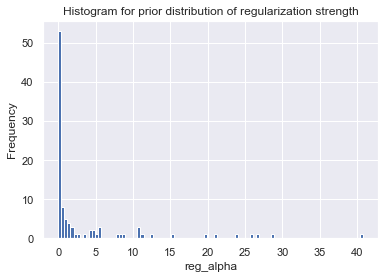

Descriptive statistics:
 count    100.000000
mean       3.553046
std        7.332586
min        0.002524
25%        0.023486
50%        0.213444
75%        2.714939
max       40.747490
dtype: float64


In [4]:
# Inspect prior distribution for reg_alpha
reg_alpha_distr = hp.loguniform('n_estimators', -6, 4)
samples = [pyll.stochastic.sample(reg_alpha_distr) for i in range(100)]

# Plot
pd.Series(samples).plot(kind='hist', bins=100)
plt.xlabel('reg_alpha')
plt.title('Prior distribution of regularization strength')
plt.show()

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe())

Looking at the minimum, maximum, and median, these values look good, so let's go with these parameters.

Now let's decide on an appropriate prior distribution for gamma, the minimum loss reduction that we require to further partition a node. I will use a lognormal distribution bounded between 0 and 0.5.  The challenge is to define this in hyperopt, because it bounds the distribution by the exponential function of the upper and lower bounds supplied as the parameters. Thus, in order to get a lower bound of 0, we would have to pass log(0) or -$\infty$ as the parameter. I solved this problem by passing the log of a small number as the lower bound, and then subtract the small number from the final distribution when adjusting the parameters.

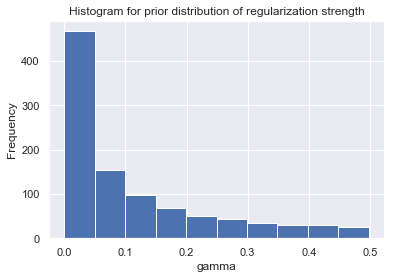

Descriptive statistics:
 count    1000.000000
mean        0.112962
std         0.128145
min         0.000022
25%         0.015788
50%         0.056480
75%         0.175346
max         0.498220
dtype: float64


In [5]:
# Inspect prior distribution for gamma
gamma_distr = hp.loguniform('n_estimators', 
                            np.log(small_number), 
                            np.log(0.5 + small_number))

samples = [pyll.stochastic.sample(gamma_distr) - small_number
               for i in range(1000)]

# Plot
pd.Series(samples).plot(kind='hist')
plt.xlabel('gamma')
plt.title('Prior distribution of regularization strength')
plt.show()

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe())

In [3]:
small_number = 0.01 # To adjust lower bound for Gamma
space = {
    # Parameters that we are going to tune (Note that these may be modified
    # in objective function to convert to integer or to set min or max.)
    'eta':.3,  # Start with a higher learning rate for speed
    'objective':'binary:logistic',
    'eval_metric':'map',
    'scale_pos_weight': 5,  # Balance classes
    'max_depth': hp.normal('max_depth', 6, 2),
    'min_child_weight': hp.normal('min_child_weight', 4, 2), 
    'gamma': hp.loguniform('gamma', # small number will be subtracted later
                            np.log(small_number), 
                            np.log(0.5 + small_number)),
    'subsample': hp.normal('subsample', 0.75, 0.2), 
    'colsample_bytree':  hp.normal('colsample_bytree', 0.75, 0.2),
    'reg_alpha': hp.loguniform('reg_alpha', -6, 4),
    'verbose_eval': False,
    'nthread': 3
}

In [94]:
# Function to convert sampled parameters to integer or make positive, etc., 
# where necessary
def adjust_params_xgb(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Convert sampled parameters to integer, where  applicable
    params['max_depth'] = round(params['max_depth'])
    
    # Make sure min_child_weight is positive
    if params['min_child_weight'] <= 0:
        params['min_child_weight'] = 0 # Set to lower bound
   
    # Subtract the small number from gamma to set 0 as lower bound
    params['gamma'] = params['gamma'] - small_number

    # Set upper or lower bunds for parameters, where applicable
    if params['max_depth'] <= 2:
        params['max_depth'] = 2
    if params['subsample'] < 0.05:
        params['subsample'] = 0.05
    if params['subsample'] > 1:
        params['subsample'] = 1
    if params['colsample_bytree'] < 0.05: 
        params['colsample_bytree'] = 0.05
    if params['colsample_bytree'] > 1:
        params['colsample_bytree'] = 0.75
    
    # Return modified parameters
    return params

In [7]:
# CSV file to track progress
progress_file_path = 'hp_progress/progress_xgb.csv'
with open(progress_file_path, 'w') as file:
    writer = csv.writer(file)
    # Write header to the file
    writer.writerow(['loss', 'params', 'n_trees'])
    
# Objective function to minimize
def objective(params, progress_file_path=progress_file_path,
              n_jobs=N_JOBS):
    """Objective function to minimize"""
    
    # Adjust parameters
    params = adjust_params_xgb(params)
    
    # Train model
    xgb_ = xgb.train(params, dtrain=data_xgb_train, 
                num_boost_round=1000,
                evals=[(data_xgb_val, "val")], 
                early_stopping_rounds=50)
    
    # Compute loss as the negative mean of the average precision scores
    # (since hyperopt can only minimize a function)
    loss = - xgb_.best_score
    
    # Save results to csv file
    with open(progress_file_path, 'a') as file:
        writer = csv.writer(file)
        writer.writerow([loss, params, xgb_.best_ntree_limit])

    # Return results
    return {'loss': loss, 'params': params, 'n_trees': xgb_.best_ntree_limit, 'status': STATUS_OK}

Now we are ready to carry out the hyperparameters optimization:

In [ ]:
# Set options
N_JOBS=3
MAX_EVALS = 100

# Minimize objective
best = fmin(objective, space, algo=tpe.suggest,
            max_evals=MAX_EVALS)

# Get the values of the optimal parameters
best_params = space_eval(space, best)

# Save best parameters
joblib.dump(best_params, 'saved_models/xgb_best_params.joblib')

Best average precision on validation set: 0.405448


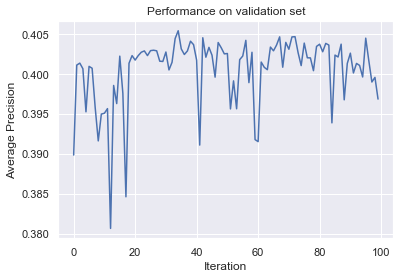

In [5]:
# Load full results from progress file
xgb_results = pd.read_csv('hp_progress/progress_xgb.csv')

# Get validation score
# Extract AP for each iteration
ap_xgb = - xgb_results.loss

print(f'Best average precision on validation set: {ap_xgb.max()}')

# Plot AP per iteration
ap_xgb.plot()
plt.title('Performance on validation set')
plt.ylabel('Average Precision')
plt.xlabel('Iteration');

Now that we have identified the best parameters, let's re-estimate the model with a lower learning rate to get another boost in accuracy.

In [ ]:
# Set other constants again, if necessary
small_number = 0.01
# Load and adjust best parameters from disk, if necessary
best_params = joblib.load('saved_models/xgb_best_params.joblib')
best_params = adjust_params_xgb(best_params)

# Decrease learning rate
best_params['eta'] = 0.05

# Fit the model with the optimal hyperparamters and lower learning rate
xgb_best = xgb.train(best_params,
                    dtrain=data_xgb_train, 
                    num_boost_round=500000,
                    evals=[(data_xgb_val, "val")], 
                    early_stopping_rounds=5000) 

In [104]:
# Best performance on validation set with smaller learning rate
xgb_best.best_score

0.407645

In [105]:
# Optimal number of trees
xgb_best.best_ntree_limit

19113

In [109]:
## Compute average precision for test set of final model
# Compute predicitions for test set
y_score_xgb = xgb_best.predict(data_xgb_test)
# Save best predictions to disk
joblib.dump(y_score_xgb, 'predictions_test/y_proba_xgb.joblib')

# Save and print AP
ap_xgb = average_precision_score(y_test, y_xgb)
print(f'Average precision on test set: {ap_xgb}')
average_precisions['xgb'] = ap_xgb

Average precision on test set: 0.41414888290960883


In [110]:
# Save final iteration of best parameters
best_params_final = best_params
# Add optimum number of trees to best parameters
best_params_final['num_boost_round'] = xgb_best.best_ntree_limit
# Remove early stopping, because now we don't need it anymore
best_params_final['early_stopping_rounds'] = None
# Save (since it's more expensive to recalculate than for the other models)
joblib.dump(best_params_final, 'saved_models/xgb_best_params_final.joblib')

['saved_models/xgb_best_params_final.joblib']

In [111]:
# Save feature importances
fi_xgb = pd.Series(xgb_best.get_fscore()) \
            .sort_values(ascending=False)
joblib.dump(fi_xgb, 'saved_models/fi_xgb.joblib')
feature_importances['xgb'] = fi_xgb
fi_xgb

log_installment                           3138
dti                                       2844
lti                                       2701
log1p_total_il_high_credit_limit          2484
log_yearly_installment_to_inc             2455
log1p_tot_cur_bal                         2421
log1p_annual_inc                          2411
log1p_total_bal_ex_mort_to_inc            2228
log1p_revol_bal_to_inc                    2208
log_funded_amnt                           2159
log1p_avg_cur_bal                         2135
log1p_tot_hi_cred_lim                     2097
log1p_total_bal_ex_mort                   2071
log1p_tot_cur_bal_to_inc                  2000
log1p_revol_bal                           1985
log_earliest_cr_line_days                 1921
log1p_bc_open_to_buy                      1897
log1p_total_bc_limit                      1655
log1p_total_rev_hi_lim                    1543
revol_util                                1529
mo_sin_old_il_acct                        1507
log_mo_sin_ol

## Tests

### SVM RBF Grid Search

In [39]:
# Create smaller subsets from data for SVMs
X_train_s, y_train_s = resample(
    X_train, y_train, 
    replace=False, n_samples=20000, random_state=1)
    
# X_test_s, y_test_s = resample(
#     X_test, y_test, 
#     replace=False, n_samples=20000, random_state=1)

In [40]:
# Project data onto the first 30 principal components
pca = PCA(n_components=30)
X_train_pc = pca.fit_transform(X_train_s) 
X_test_pc = pca.transform(X_test)

In [41]:
%%time
svm_rbf_1 = SVC(kernel='rbf', probability=False, 
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'gamma': np.logspace(-5, 1, 8)}
# Define indices for validation split (instead of proper cross-validation)
split_indices = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_rbf_gs = GridSearchCV(svm_rbf_1, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_rbf_gs.fit(X_train_pc, y_train_s)

# Save model
joblib.dump(svm_rbf_gs, 'saved_models/svm_rbf_gs.joblib')

Wall time: 1h 45min


In [42]:
# Load model
svm_rbf_gs = joblib.load('saved_models/svm_rbf_gs.joblib')

In [ ]:
# Prediction of class
y_pred_svm_rbf_1 = svm_rbf_gs.predict(X_test_pc)

# Distance from separating hyperplane
y_pred_distance_svm_rbf_1 = svm_rbf_gs.decision_function(X_test_pc)

average_precision_score(y_test, y_pred_distance_svm_rbf_1)

# classification_reports_1['SVM (RBF Kernel)'] = \
#     classification_report(y_test, y_pred_svm_rbf_1)

In [ ]:
# Prediction of class
y_pred_svm_rbf_1 = svm_rbf_gs.predict(X_test_pc)

# Distance from separating hyperplane
y_pred_distance_svm_rbf_1 = svm_rbf_gs.decision_function(X_test_pc)

In [45]:
average_precision_score(y_test, y_pred_distance_svm_rbf_1)

# classification_reports_1['SVM (RBF Kernel)'] = \
#     classification_report(y_test, y_pred_svm_rbf_1)

0.384421029746738

In [ ]:
# Visualize grid search results
def gs_heatmap(gridsearchcv, x_digits=0, y_digits=0,
               x_scientific_notation=True, y_scientific_notation=True):
    """Visualizes validation accuracy from grid search over two hyperparameters."""
    
    # Print test score and  hyperparameters
    print('Best validation score: {:.3f}, best hyperparameters: '
                .format(gridsearchcv.best_score_), 
          gridsearchcv.best_params_)
      
    # Get mean validation scores
    scores = pd.DataFrame(
        gridsearchcv.cv_results_['mean_test_score'])
    # Get values for hyperparameters
    params = pd.DataFrame(
        gridsearchcv.cv_results_['params'])
    # Concatenate validation scores and hyperparameters 
    scores_w_params = pd.concat([params, scores], 
                                  axis=1)
    # Set first two columns, which correspond to parameters, as index.
    # Then unstack.
    index_cols = list(scores_w_params.columns)[:2]
    scores_2d = scores_w_params.set_index(index_cols) \
                    .squeeze() \
                    .unstack()
    
    # Create desired formatting string for axes (scientific notation and digits)
    if x_scientific_notation == True:
        x_notation = 'E' 
    else: 
        x_notation = 'F'
    x_formatting = '{:.' + str(x_digits) + x_notation + '}'

    if y_scientific_notation == True:
        y_notation = 'E' 
    else: 
        y_notation = 'F'
    y_formatting = '{:.' + str(y_digits) + y_notation + '}'

    # Plot
    fig, ax = plt.subplots()
    sns.heatmap(scores_2d, ax=ax,
                xticklabels=[x_formatting.format(x) for  x in scores_2d.columns],
                yticklabels=[y_formatting.format(y) for y in scores_2d.index])
    ax.set_title('Validation accuracy')
    
    
gs_heatmap(svm_rbf_gs) #, x_digits=1, x_scientific_notation=False)

In [ ]:
pd.DataFrame(svm_rbf_gs.cv_results_)

## Save/Load

In [21]:
# Save
joblib.dump(average_precisions, 'saved_models/average_precisions.joblib')
joblib.dump(feature_importances, 'saved_models/feature_importances.joblib')

['saved_models/feature_importances.joblib']

In [11]:
# Load
average_precisions = joblib.load('saved_models/average_precisions.joblib')
feature_importances = joblib.load('saved_models/feature_importances.joblib')

In [12]:
average_precisions

{'lr': 0.39224740694750637,
 'svm_lin': 0.3913884831950885,
 'rf': 0.3939554379468981,
 'xgb': 0.41414888290960883}

In [14]:
feature_importances.keys()

dict_keys(['xgb', 'lr'])